In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load data
df = pd.read_csv('train.csv')
df['labels'] = [0 if x == 'nonevent' else 1 for x in df['class4']]

# Features and labels
# partlybad无用可去掉
X = df.drop(columns=['id', 'class4', 'labels', 'date', 'partlybad'])
y = df['labels']

# Split data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [54]:
# 评价指标：去掉多分类的准确度，二分类准确度和困惑度 权重50：50
def custom_score_func(y_true, y_pred_proba, **kwargs):
    y_true = np.array(y_true)
    
    if y_pred_proba.ndim == 2:
        y_prob = y_pred_proba[:, 1]
    else:
        y_prob = y_pred_proba
        
    if len(y_true) != len(y_prob):
        return 0.0
           
    # Binary Accuracy 
    y_pred_class = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred_class)
    
    # Perplexity 
    prob_correct = np.where(y_true == 1, y_prob, 1 - y_prob)
    prob_correct = np.clip(prob_correct, 1e-15, 1 - 1e-15)
    perplexity = np.exp(-np.mean(np.log(prob_correct)))
    perplexity_term = max(0, min(1, 2 - perplexity))
    
    # Final Score
    final_score = 0.5 * acc + 0.5 * perplexity_term
    
    return final_score

custom_scorer = make_scorer(custom_score_func, needs_proba=True)

scoring_dict = {
    'Custom_Score': custom_scorer,
    'Accuracy': 'accuracy',
    'ROC_AUC': 'roc_auc'
}

# Logistic with $L_1$ Regularization

In [55]:
# Create a pipeline with scaling and logistic regression
pipe_l1 = Pipeline([('scaler', StandardScaler()),  
                    ('clf', LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=10000, random_state=42))
])

In [56]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'clf__solver': ['saga', 'liblinear'],  
    # 'clf__C': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]
    # 'clf__C': np.arange(0.1, 1.1, 0.1)
    # 'clf__C': np.arange(0.2, 0.7, 0.05)
    'clf__C': np.arange(0.3, 0.6, 0.01)

}
grid = GridSearchCV(pipe_l1, param_grid, cv=5, scoring=scoring_dict, refit='Custom_Score', n_jobs=-1, verbose=1)
grid.fit(X, y)

# print best params
print("best params:", grid.best_params_)
print("best score:",grid.best_score_)

best_idx = grid.best_index_ 

best_acc = grid.cv_results_['mean_test_Accuracy'][best_idx]
best_auc = grid.cv_results_['mean_test_ROC_AUC'][best_idx]

print(f"best Accuracy: {best_acc:.4f}")
print(f"best ROC-AUC: {best_auc:.4f}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
best params: {'clf__C': np.float64(0.4300000000000001), 'clf__solver': 'liblinear'}
best score: 0.4488888888888889
best Accuracy: 0.8978
best ROC-AUC: 0.9493


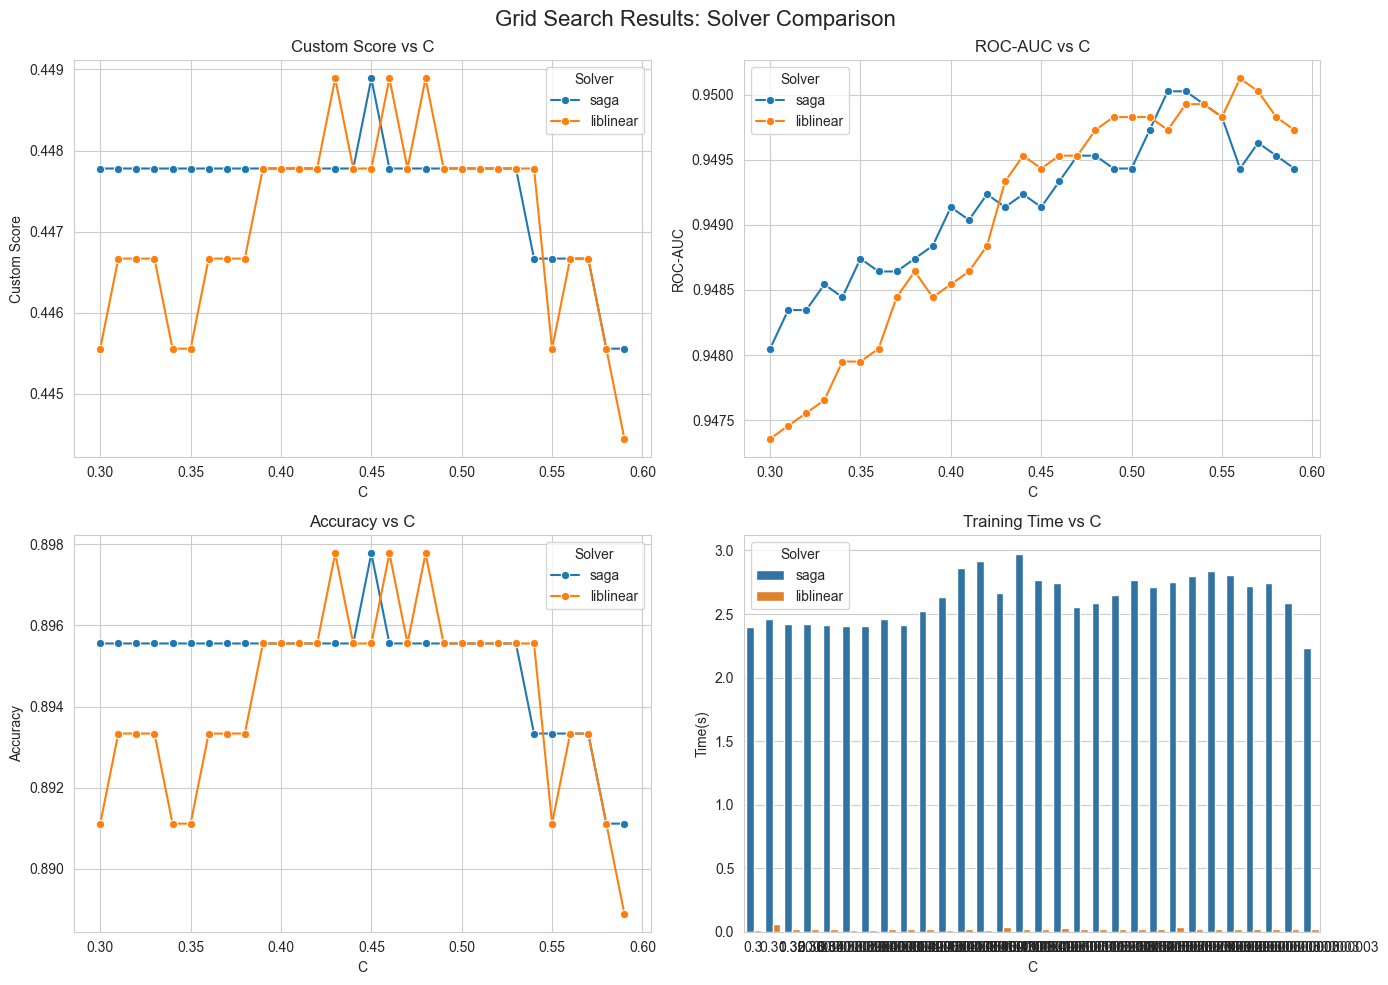

In [57]:
results = pd.DataFrame(grid.cv_results_)
cols = ['param_clf__C', 'param_clf__solver', 'mean_test_Custom_Score', 'mean_test_Accuracy', 'mean_test_ROC_AUC', 'mean_fit_time']
df_res = results[cols].copy()
df_res.columns = ['C', 'Solver', 'Custom Score', 'Accuracy', 'ROC-AUC', 'Time(s)']

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Grid Search Results: Solver Comparison', fontsize=16)

# 图1: Custom Score 随 C 变化
sns.lineplot(data=df_res, x='C', y='Custom Score', hue='Solver', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('Custom Score vs C')

# 图2: ROC-AUC 随 C 变化
sns.lineplot(data=df_res, x='C', y='ROC-AUC', hue='Solver', marker='o', ax=axes[0, 1])
axes[0, 1].set_title('ROC-AUC vs C')

# 图3: Accuracy 随 C 变化
sns.lineplot(data=df_res, x='C', y='Accuracy', hue='Solver', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('Accuracy vs C')

# 图4: 训练耗时对比 (条形图)
sns.barplot(data=df_res, x='C', y='Time(s)', hue='Solver', ax=axes[1, 1])
axes[1, 1].set_title('Training Time vs C')

plt.tight_layout()
plt.show() # 在 Jupyter 中这会直接显示图表，或者保存为文件
# plt.savefig('grid_search_results.png')

In [58]:
# Train the model with the best parameters
pipe_l1 = Pipeline([('scaler', StandardScaler()),  
                    ('clf', LogisticRegression(penalty='l1', solver='liblinear', C=0.43, max_iter=10000, random_state=42))
]) 
pipe_l1.fit(X_train, y_train)

# Evaluate the model
y_pred = pipe_l1.predict(X_valid)
y_prob = pipe_l1.predict_proba(X_valid)[:, 1]
print("Accuracy:", accuracy_score(y_valid, y_pred))
print("ROC-AUC:", roc_auc_score(y_valid, y_prob))

# Feature selection based on L1 regularization
coef = pipe_l1.named_steps['clf'].coef_[0]
selected_features = X.columns[coef != 0]
print("\nFeatures selected by L1 regularization:", len(selected_features))
print("Selected features by L1:", selected_features)

Accuracy: 0.9
ROC-AUC: 0.9451851851851851

Features selected by L1 regularization: 23
Selected features by L1: Index(['CO242.mean', 'Glob.mean', 'H2O336.mean', 'H2O504.mean', 'H2O672.mean',
       'NO42.std', 'NOx42.std', 'NOx504.std', 'O342.mean', 'O384.mean',
       'Pamb0.mean', 'Pamb0.std', 'PTG.mean', 'RGlob.mean', 'RHIRGA42.std',
       'RHIRGA672.mean', 'SO2168.mean', 'SO2168.std', 'SWS.mean', 'T42.mean',
       'T672.mean', 'CS.mean', 'CS.std'],
      dtype='object')


In [61]:
# Use selected features to train a new model
X_selected = df[selected_features]
pipe_l1_selected = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='l1', solver='liblinear', C=0.43, max_iter=10000, random_state=42))
])
pipe_l1_selected.fit(X_selected, y)

# Evaluate the model
y_pred = pipe_l1_selected.predict(X_valid[selected_features])
y_prob = pipe_l1_selected.predict_proba(X_valid[selected_features])[:, 1]
print("Accuracy:", accuracy_score(y_valid, y_pred))
print("ROC-AUC:", roc_auc_score(y_valid, y_prob))

Accuracy: 0.8888888888888888
ROC-AUC: 0.9496296296296296


In [66]:
# Predict on test set
df_test = pd.read_csv('test.csv')
X_test = df_test[selected_features]
y_test_prob = pipe_l1_selected.predict_proba(X_test)[:, 1]

# Binary class hard prediction
y_test_pred_class2 = (y_test_prob >= 0.5).astype(int)

# Map to class4 (simple strategy: all events are considered Ia)
class4_pred = np.where(y_test_pred_class2 == 1, 'Ib', 'nonevent')

df_test['class4'] = class4_pred  # 添加 class4 列
df_test['p'] = y_test_prob       # 添加 p 列

df_test.to_csv('binary_logistic.csv', index=False)

print("=== 预测结果统计 ===")
counts = df_test['class4'].value_counts()
print(counts)

=== 预测结果统计 ===
class4
nonevent    513
Ib          452
Name: count, dtype: int64


# Random Forest

In [ ]:
# Random Forest with Hyperparameter Tuning
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Hayperparameter grid
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 0.5, 1.0],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
# Train the Random Forest with the best parameters
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,          
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',     
    bootstrap=True,
    random_state=42,
    n_jobs=-1                
)

rf.fit(X_train, y_train)

In [ ]:
# Evaluate the Random Forest model
y_valid_pred = rf.predict(X_valid)
y_valid_prob = rf.predict_proba(X_valid)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Random Forest AUC:", roc_auc_score(y_valid, y_valid_prob))

In [ ]:
# Predict on test set
df_test = pd.read_csv('test.csv')
X_test = df_test[selected_features]
y_test_prob_rf = pipe_l1_selected.predict_proba(X_test)[:, 1]

# Binary class hard prediction
y_test_pred_rf = (y_test_prob_rf >= 0.5).astype(int)

# Map to class4 (simple strategy: all events are considered Ia)
class4_pred = np.where(y_test_pred_rf == 1, 'Ia', 'nonevent')

submission_rf = pd.DataFrame({
    'id': df_test['id'],
    'class4': class4_pred,
    'p': y_test_prob_rf
})

submission_rf.to_csv('submission_rf.csv', index=False)

In [ ]:
# Obtain the important features from Random Forest
feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20))

# XGBoost

In [ ]:
# XGBoost Classifier
xgb = XGBClassifier(
    n_estimators=600,        
    max_depth=4,          
    learning_rate=0.03,     
    subsample=0.8,          
    colsample_bytree=0.8,  
    objective='binary:logistic',
    eval_metric='logloss',  
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

# Evaluate the XGBoost model
y_valid_prob = xgb.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_prob >= 0.5).astype(int)
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("AUC:", roc_auc_score(y_valid, y_valid_prob))
print("Log-loss:", log_loss(y_valid, y_valid_prob))

In [ ]:
# Predict on test set
df_test = pd.read_csv('test.csv')
X_test = df_test[selected_features]
y_test_prob_xgb = pipe_l1_selected.predict_proba(X_test)[:, 1]

# Binary class hard prediction
y_test_pred_xgb = (y_test_prob_xgb >= 0.5).astype(int)

# Map to class4 (simple strategy: all events are considered Ia)
class4_pred = np.where(y_test_pred_xgb == 1, 'Ia', 'nonevent')

submission_xgb = pd.DataFrame({
    'id': df_test['id'],
    'class4': class4_pred,
    'p': y_test_prob_xgb
})

submission_xgb.to_csv('submission_xgb.csv', index=False)

# SVM

In [ ]:
# Hyperparameter tuning for SVM with L1 regularization
param_grid = {'clf__C': [0.01, 0.05, 0.1, 0.5, 1.0]}

grid_svm = GridSearchCV(estimator=svm_l1, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

grid_svm.fit(X, y)

print("Best params:", grid_svm.best_params_)
print("Best CV score:", grid_svm.best_score_)

In [ ]:
# Train the model with the best parameters
svm_l1 = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(penalty='l1', loss='squared_hinge', dual=False, C=0.1, max_iter=5000, random_state=42))
])

svm_l1.fit(X_train, y_train)

# Evaluate the model
y_valid_pred = svm_l1.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("AUC (using decision_function):", 
      roc_auc_score(y_valid, svm_l1.decision_function(X_valid)))

# Selected features based on SVM with L1 regularization
coef = svm_l1.named_steps['clf'].coef_[0]
selected_features_svm = X.columns[coef != 0]
print("Number of selected features:", len(selected_features_svm))
print(selected_features_svm)

In [ ]:
# Retrain model with selected features
pipe_l1_selected = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='linear', C=1.0, probability=True, random_state=42))
])
pipe_l1_selected.fit(X[selected_features_svm], y)

# Evaluate the model
y_valid_pred = pipe_l1_selected.predict(X_valid[selected_features_svm])
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("AUC (using decision_function):", 
      roc_auc_score(y_valid, pipe_l1_selected.decision_function(X_valid[selected_features_svm])))

In [ ]:
# Predict on test set
df_test = pd.read_csv('test.csv')
X_test = df_test[selected_features_svm]

# Calibrated classifier for probability estimates
svm_l1_calibrated = CalibratedClassifierCV(estimator=pipe_l1_selected,method='sigmoid',cv=5)
svm_l1_calibrated.fit(X[selected_features_svm], y)
y_test_prob_svm = svm_l1_calibrated.predict_proba(X_test[selected_features_svm])[:, 1]

# Binary class hard prediction
y_test_pred_class2 = (y_test_prob_svm >= 0.5).astype(int)
class4_pred = np.where(y_test_pred_class2 == 1, 'Ia', 'nonevent')

submission_xgb = pd.DataFrame({
    'id': df_test['id'],
    'class4': class4_pred,
    'p': y_test_prob_svm
})

submission_xgb.to_csv('submission_svm.csv', index=False)